<a href="https://colab.research.google.com/github/Maxmuleiv/Proyecto-Industrial/blob/master/AnalisisPobrezaMultidimensional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación Packages

In [1]:
%reset-f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importación BD

In [0]:
url1="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/pobreza5d.csv?raw=true" #url base datos 
url11="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/carencias.csv?raw=true"
datos5D = pd.read_csv(url11,";") #importación base datos pobres 5d

In [0]:
url2="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/dimensiones5D.csv?raw=true" #url base datos 
url22="https://github.com/Maxmuleiv/Proyecto-Industrial/blob/master/dimensiones.csv?raw=true"
dimensiones = pd.read_csv(url22,";") #importación base datos por dimension

# Definicion funciones

In [0]:
# FUNCION PARA OBTENCION HEATMAPS POR TIPO DE CORRELACION (PEARSON, KENDALL Y SPEARMAN)
def creacion_heatmap(Nombre_metodo,Tabla_variables,Negativos,Comentario_grafico):
  

  if  Negativos==False:
    color_min=-0.01
  else:
    color_min=-0.12

  Tabla_correlaciones = Tabla_variables.corr(method=Nombre_metodo)
  plt.figure(figsize = (20,10)) #arreglar el tamaño del gráfico

  mask = np.zeros(Tabla_correlaciones.shape, dtype=bool) #eliminacion datos simetricos
  mask[np.triu_indices(len(mask))] = True

  mapa=sb.heatmap(Tabla_correlaciones.values.round(2), xticklabels=Tabla_correlaciones.columns, # heatmap pearson
            yticklabels=Tabla_correlaciones.columns,vmin = color_min, vmax = 0.12, center = 0, cmap = "RdBu",annot=True, mask=mask, linewidths=3)

  b, t = mapa.get_ylim() # identificar limites de corte
  mapa.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".png",bbox_inches="tight")
  plt.savefig("Heatmap_"+Nombre_metodo+"_"+Comentario_grafico+".svg",bbox_inches="tight")

  return
  plt.show()

# Cálculo correlaciones carencias 5D

In [0]:
pearson5d = datos5D.corr(method='pearson')
kendall5d = datos5D.corr(method='kendall')
spearman5d = datos5D.corr(method='spearman')

In [6]:
pearson5d

,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
Asistencia,1.000000,0.001807,-0.001669,0.057216,-0.035233,-0.033008,-0.000002,-0.023322,-0.093290,-0.013697,-0.072353,-0.075101,0.021848,0.014863,0.028150
Rezago escolar,0.001807,1.000000,0.011478,-0.003866,-0.053011,-0.027417,-0.015600,-0.009737,-0.096590,-0.015257,-0.081555,-0.065003,0.005373,0.012865,0.026042
Escolaridad,-0.001669,0.011478,1.000000,-0.095546,-0.185647,-0.170200,-0.148758,-0.077000,-0.025015,-0.101716,0.043571,-0.062650,-0.001392,-0.063631,-0.047749
Malnutricion infantil,0.057216,-0.003866,-0.095546,1.000000,-0.078169,-0.035771,-0.028609,-0.023408,-0.120435,0.029542,-0.098659,-0.088984,-0.014239,0.012719,0.020964
Sistema de salud,-0.035233,-0.053011,-0.185647,-0.078169,1.000000,0.008826,0.044807,0.077482,-0.060174,-0.122584,-0.147175,-0.101106,0.030433,0.012730,-0.001617
Atencion,-0.033008,-0.027417,-0.170200,-0.035771,0.008826,1.000000,0.016871,-0.048991,0.020231,-0.077401,-0.108774,-0.031949,-0.001215,0.048181,0.026240
Ocupacion,-0.000002,-0.015600,-0.148758,-0.028609,0.044807,0.016871,1.000000,-0.161202,-0.077768,-0.066781,-0.182155,-0.058520,0.006246,0.033398,0.039229
Seguridad social,-0.023322,-0.009737,-0.077000,-0.023408,0.077482,-0.048991,-0.161202,1.000000,-0.054330,-0.101963,-0.133876,-0.367012,-0.015733,-0.000908,0.020760
Jubilaciones,-0.093290,-0.096590,-0.025015,-0.120435,-0.060174,0.020231,-0.077768,-0.054330,1.000000,-0.192563,-0.164503,-0.057774,-0.017453,-0.045674,-0.026736
Habitabilidad,-0.013697,-0.015257,-0.101716,0.029542,-0.122584,-0.077401,-0.066781,-0.101963,-0.192563,1.000000,-0.050858,-0.089167,0.039900,0.070012,0.062424


In [7]:
kendall5d

,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
Asistencia,1.000000,0.001807,-0.001669,0.057216,-0.035233,-0.033008,-0.000002,-0.023322,-0.093290,-0.013697,-0.072353,-0.075101,0.021848,0.014863,0.028150
Rezago escolar,0.001807,1.000000,0.011478,-0.003866,-0.053011,-0.027417,-0.015600,-0.009737,-0.096590,-0.015257,-0.081555,-0.065003,0.005373,0.012865,0.026042
Escolaridad,-0.001669,0.011478,1.000000,-0.095546,-0.185647,-0.170200,-0.148758,-0.077000,-0.025015,-0.101716,0.043571,-0.062650,-0.001392,-0.063631,-0.047749
Malnutricion infantil,0.057216,-0.003866,-0.095546,1.000000,-0.078169,-0.035771,-0.028609,-0.023408,-0.120435,0.029542,-0.098659,-0.088984,-0.014239,0.012719,0.020964
Sistema de salud,-0.035233,-0.053011,-0.185647,-0.078169,1.000000,0.008826,0.044807,0.077482,-0.060174,-0.122584,-0.147175,-0.101106,0.030433,0.012730,-0.001617
Atencion,-0.033008,-0.027417,-0.170200,-0.035771,0.008826,1.000000,0.016871,-0.048991,0.020231,-0.077401,-0.108774,-0.031949,-0.001215,0.048181,0.026240
Ocupacion,-0.000002,-0.015600,-0.148758,-0.028609,0.044807,0.016871,1.000000,-0.161202,-0.077768,-0.066781,-0.182155,-0.058520,0.006246,0.033398,0.039229
Seguridad social,-0.023322,-0.009737,-0.077000,-0.023408,0.077482,-0.048991,-0.161202,1.000000,-0.054330,-0.101963,-0.133876,-0.367012,-0.015733,-0.000908,0.020760
Jubilaciones,-0.093290,-0.096590,-0.025015,-0.120435,-0.060174,0.020231,-0.077768,-0.054330,1.000000,-0.192563,-0.164503,-0.057774,-0.017453,-0.045674,-0.026736
Habitabilidad,-0.013697,-0.015257,-0.101716,0.029542,-0.122584,-0.077401,-0.066781,-0.101963,-0.192563,1.000000,-0.050858,-0.089167,0.039900,0.070012,0.062424


In [8]:
spearman5d

,Asistencia,Rezago escolar,Escolaridad,Malnutricion infantil,Sistema de salud,Atencion,Ocupacion,Seguridad social,Jubilaciones,Habitabilidad,Servicios basicos,Entorno,Apoyo y participacion social,Trato igualitario,Seguridad
Asistencia,1.000000,0.001807,-0.001669,0.057216,-0.035233,-0.033008,-0.000002,-0.023322,-0.093290,-0.013697,-0.072353,-0.075101,0.021848,0.014863,0.028150
Rezago escolar,0.001807,1.000000,0.011478,-0.003866,-0.053011,-0.027417,-0.015600,-0.009737,-0.096590,-0.015257,-0.081555,-0.065003,0.005373,0.012865,0.026042
Escolaridad,-0.001669,0.011478,1.000000,-0.095546,-0.185647,-0.170200,-0.148758,-0.077000,-0.025015,-0.101716,0.043571,-0.062650,-0.001392,-0.063631,-0.047749
Malnutricion infantil,0.057216,-0.003866,-0.095546,1.000000,-0.078169,-0.035771,-0.028609,-0.023408,-0.120435,0.029542,-0.098659,-0.088984,-0.014239,0.012719,0.020964
Sistema de salud,-0.035233,-0.053011,-0.185647,-0.078169,1.000000,0.008826,0.044807,0.077482,-0.060174,-0.122584,-0.147175,-0.101106,0.030433,0.012730,-0.001617
Atencion,-0.033008,-0.027417,-0.170200,-0.035771,0.008826,1.000000,0.016871,-0.048991,0.020231,-0.077401,-0.108774,-0.031949,-0.001215,0.048181,0.026240
Ocupacion,-0.000002,-0.015600,-0.148758,-0.028609,0.044807,0.016871,1.000000,-0.161202,-0.077768,-0.066781,-0.182155,-0.058520,0.006246,0.033398,0.039229
Seguridad social,-0.023322,-0.009737,-0.077000,-0.023408,0.077482,-0.048991,-0.161202,1.000000,-0.054330,-0.101963,-0.133876,-0.367012,-0.015733,-0.000908,0.020760
Jubilaciones,-0.093290,-0.096590,-0.025015,-0.120435,-0.060174,0.020231,-0.077768,-0.054330,1.000000,-0.192563,-0.164503,-0.057774,-0.017453,-0.045674,-0.026736
Habitabilidad,-0.013697,-0.015257,-0.101716,0.029542,-0.122584,-0.077401,-0.066781,-0.101963,-0.192563,1.000000,-0.050858,-0.089167,0.039900,0.070012,0.062424


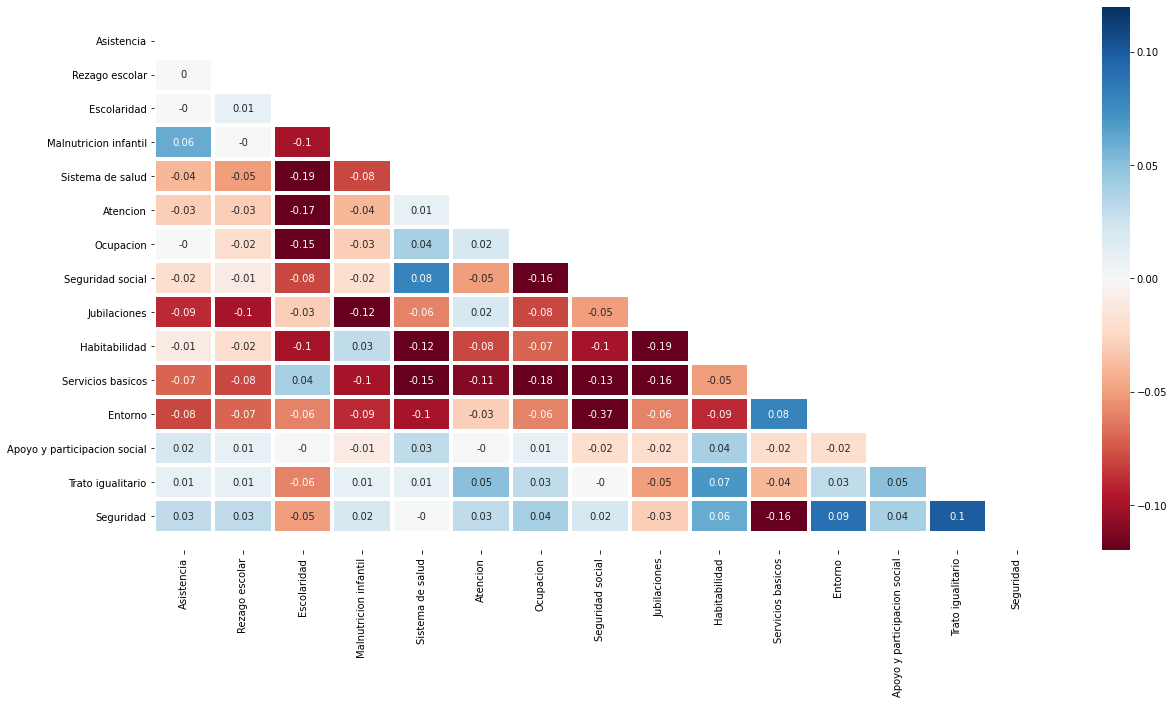

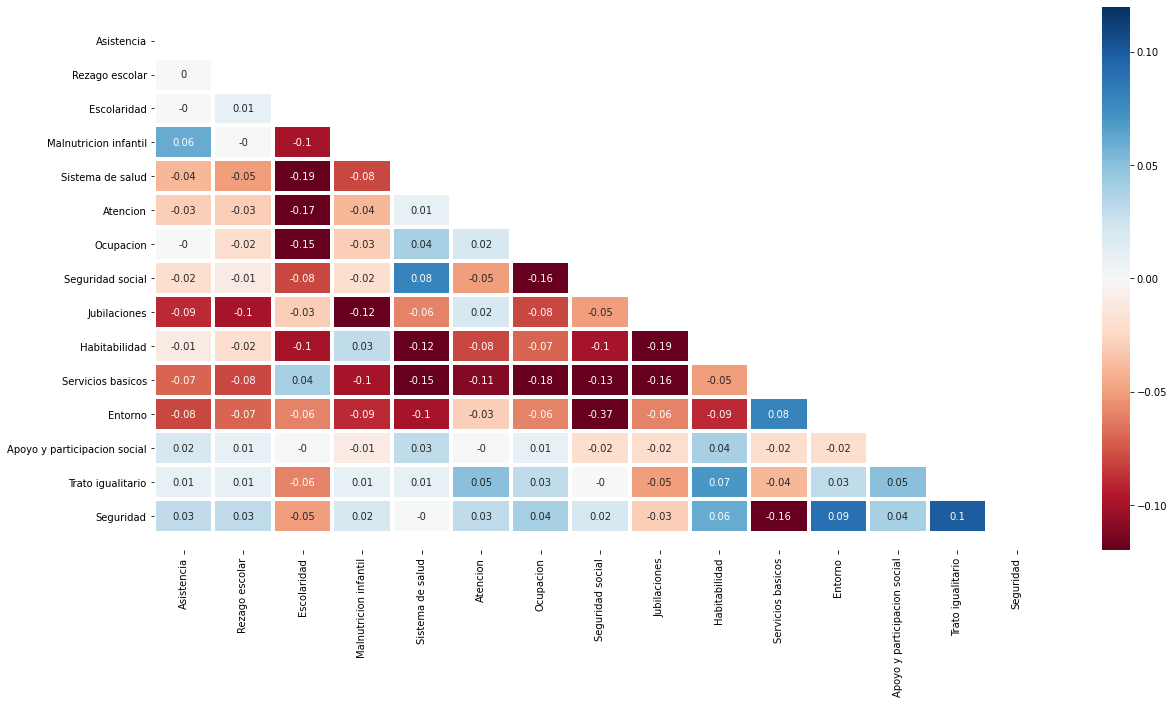

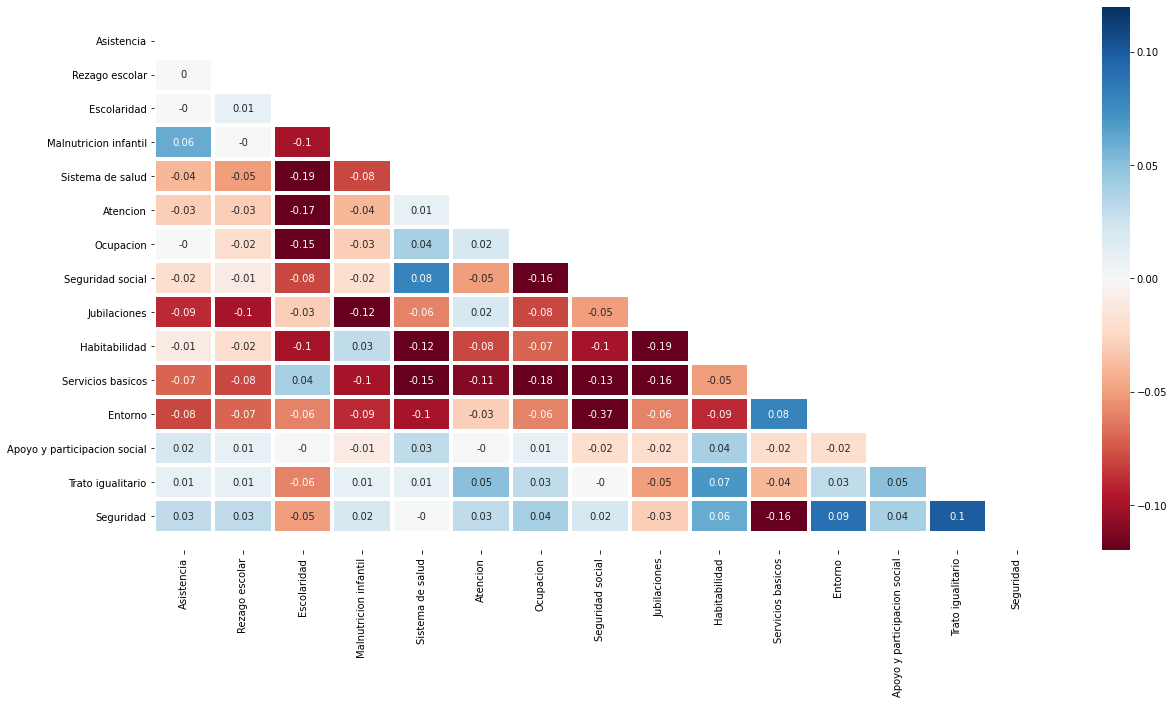

In [9]:
creacion_heatmap("pearson",datos5D,True,"Correlaciones")
creacion_heatmap("kendall",datos5D,True,"Correlaciones")
creacion_heatmap("spearman",datos5D,True,"Correlaciones")

In [0]:
# importacion datos correlaciones excel

pearson5d.to_excel(excel_writer = "pearson5d.xlsx")
kendall5d.to_excel(excel_writer = "kendall5d.xlsx")
spearman5d.to_excel(excel_writer = "spearman5d.xlsx")

# Cálculo correlaciones por dimensiones agrupadas (5D)


In [0]:
pearsonDim = dimensiones.corr(method='pearson')
kendallDim = dimensiones.corr(method='kendall')
spearmanDim = dimensiones.corr(method='spearman')

In [12]:
pearsonDim

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
Educacion,1.000000,-0.232382,-0.189302,-0.139436,-0.024152
Salud,-0.232382,1.000000,-0.042665,-0.268346,0.043461
Trabajo y seguridad social,-0.189302,-0.042665,1.000000,-0.507549,-0.003020
Vivienda y entorno,-0.139436,-0.268346,-0.507549,1.000000,0.018705
Redes y cohesion social,-0.024152,0.043461,-0.003020,0.018705,1.000000


In [13]:
kendallDim

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
Educacion,1.000000,-0.229779,-0.174546,-0.126619,-0.023794
Salud,-0.229779,1.000000,-0.038501,-0.252372,0.044082
Trabajo y seguridad social,-0.174546,-0.038501,1.000000,-0.469646,-0.003146
Vivienda y entorno,-0.126619,-0.252372,-0.469646,1.000000,0.021767
Redes y cohesion social,-0.023794,0.044082,-0.003146,0.021767,1.000000


In [14]:
spearmanDim

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
Educacion,1.000000,-0.240173,-0.190089,-0.139631,-0.025137
Salud,-0.240173,1.000000,-0.040991,-0.271982,0.045523
Trabajo y seguridad social,-0.190089,-0.040991,1.000000,-0.513299,-0.003386
Vivienda y entorno,-0.139631,-0.271982,-0.513299,1.000000,0.023718
Redes y cohesion social,-0.025137,0.045523,-0.003386,0.023718,1.000000


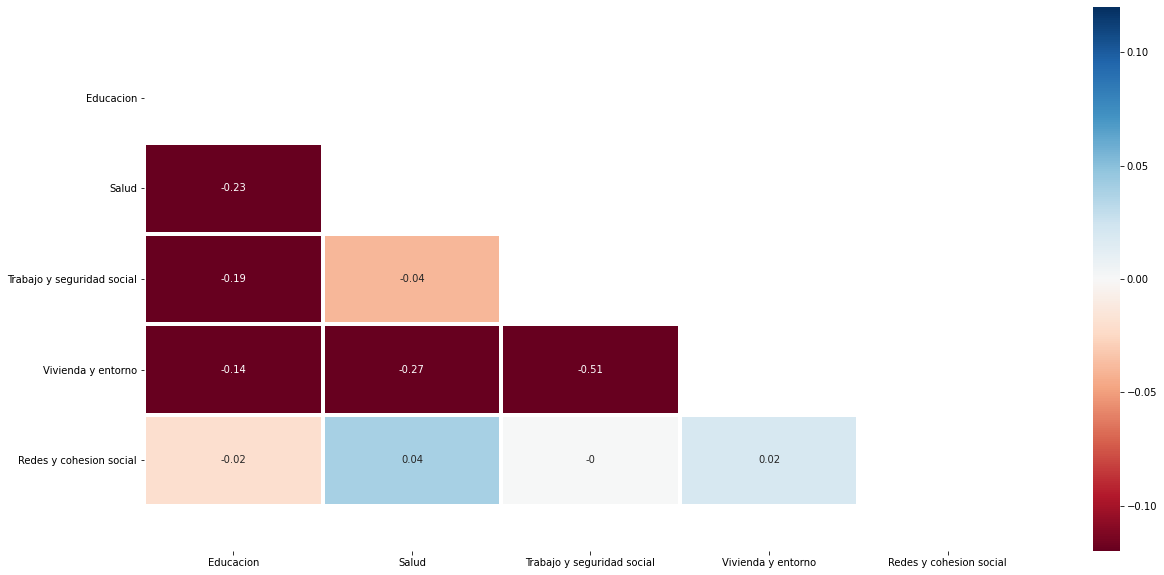

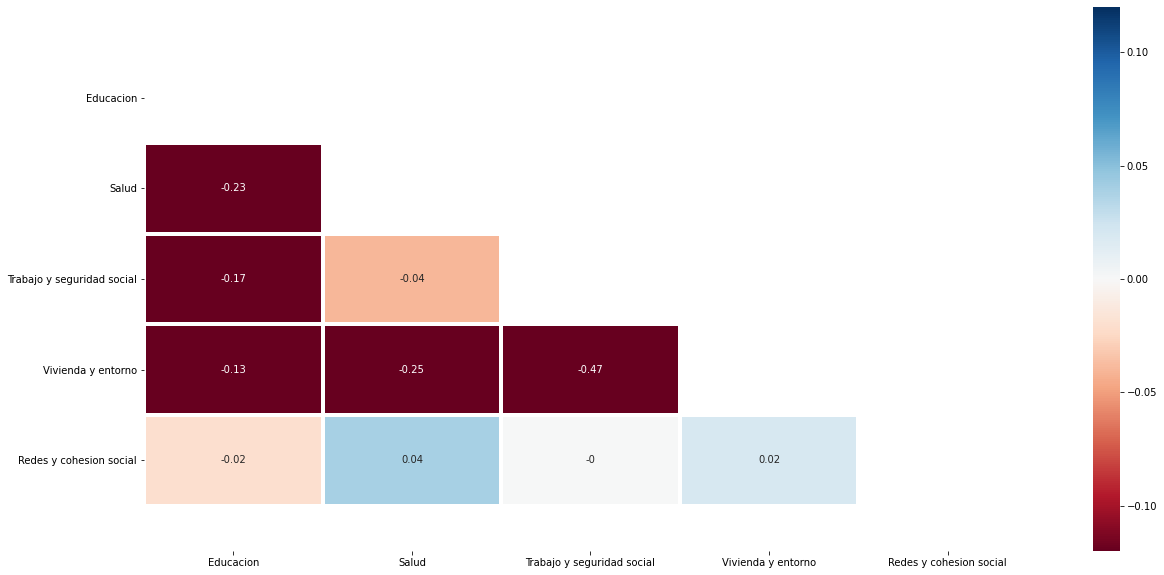

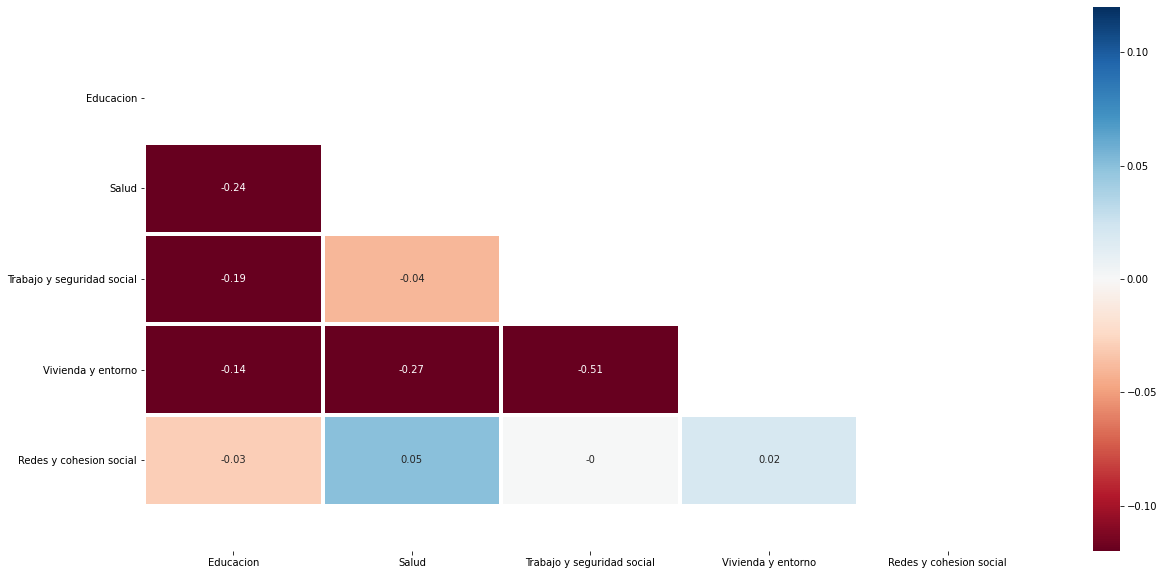

In [15]:
# OBTENCION HEATMAPS PEARSON, KENDALL Y SPEARMAN POR DIMENSIONES

creacion_heatmap("pearson",dimensiones,True,"DIM")
creacion_heatmap("kendall",dimensiones,True,"DIM")
creacion_heatmap("spearman",dimensiones,True,"DIM")


In [0]:
# exportacion datos correlaciones excel

pearsonDim.to_excel(excel_writer = "pearsonDim.xlsx")
kendallDim.to_excel(excel_writer = "kendallDim.xlsx")
spearmanDim.to_excel(excel_writer = "spearmanDim.xlsx")

# Análisis red carencias

In [17]:
#transformación datos insice matriz de correlaciones, en este caso se usa pearson
indices = pearson5d.index.values
# transformación datos carencias a matriz, se emplea en este caso pearson
matrizCarencias = np.asmatrix(pearson5d)
#Creación de grafo con datos de la matriz de correlaciones Matriz5d
Gcarencias = nx.from_numpy_matrix(matrizCarencias)

#etiquetado de nosos para que coincidan con nombres de carencias
Gcarencias = nx.relabel_nodes(Gcarencias,lambda x: matrizCarencias[x,x]) # revisar aca, redefinicion de las etiquetas

#Muestra los arcos con sus respectivos pesos
Gcarencias.edges(data=True)

EdgeDataView([(1.0, 1.0, {'weight': 1.0})])

In [0]:
#Funcion para crear redes en base a correlaciones

def create_corr_network_1(G):
    #creacion lista de arcos y lista de pesos
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #Layout circular del grafo
    positions=nx.circular_layout(G)
    
    #Tamaño de la figura
    plt.figure(figsize=(15,15))

    #Ploteo de nodos
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    
    #Estilo etiquetas
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #Ploteo de arcos
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid')
    
    # Presentar el gráfico sin eje
    plt.axis('off')
   
    # Importación imagen grafo
    plt.savefig("grafocorr.png", format="PNG")
    plt.savefig("grafocorr.svg", format="SVG")
    plt.show() 
    create_corr_network_1(G)

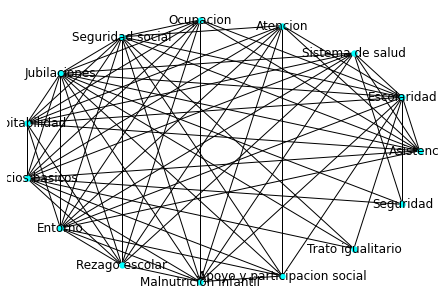

In [19]:
# Transform it in a links data frame (3 columns only):
links = pearson5d.stack().reset_index()
links.columns = ['var1', 'var2','value']
links
 
# eliminar correlaciones autorreferenciadas
links_filtered=links.loc[ (links['value'] < 0) & (links['var1'] != links['var2']) ]
links_filtered
 
# Creación gráfico
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
nx.draw_circular(G, with_labels=True, node_color='cyan', node_size=40, edge_color='black', linewidths=0.01, font_size=12)

#b, t = mapa5d.get_ylim() # identificar limites de corte
#mapa5d.set_ylim(b + 0.5, t - 0.5) #redefinir limites de corte

# Cálculo coeficiente de determinación R cuadrado para dimensiones

In [20]:
dimensiones.head()

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
0,1,1,1,1,0
1,1,0,3,2,2
2,0,0,1,3,2
3,0,0,1,2,2
4,0,1,0,2,1


In [21]:
dimensiones2=dimensiones.T
dimensiones2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12352,12353,12354,12355,12356,12357,12358,12359,12360,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370,12371,12372,12373,12374,12375,12376,12377,12378,12379,12380,12381,12382,12383,12384,12385,12386,12387,12388,12389,12390,12391
Educacion,1,1,0,0,0,0,0,0,1,1,2,1,1,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,2,1,0,1,0,1,1,1,1,1,1,0,...,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,1
Salud,1,0,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,1,1,0,1,1,1,1,1,2,...,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
Trabajo y seguridad social,1,3,1,1,0,0,1,1,1,0,1,1,1,2,2,2,1,1,0,2,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,...,1,1,1,0,0,0,0,1,2,1,1,2,1,2,1,1,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,1,1,1,1,2,1,0,1,2
Vivienda y entorno,1,2,3,2,2,2,1,2,2,2,0,1,0,0,1,1,1,1,1,0,1,2,1,1,1,1,2,1,1,2,1,0,1,1,2,1,1,2,1,2,...,1,1,1,3,3,2,3,1,1,1,2,0,1,2,1,1,2,2,2,1,2,1,2,2,2,2,2,2,2,2,1,2,2,1,1,2,2,3,1,1
Redes y cohesion social,0,2,2,2,1,2,2,2,0,2,1,0,0,0,0,0,1,1,1,1,0,2,0,1,0,0,0,1,1,1,1,1,0,0,1,2,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
# cálculo coef. 
dimensionesR=np.corrcoef(dimensiones2)

In [23]:
pd.DataFrame(dimensionesR).head()

,0,1,2,3,4
0,1.000000,-0.232382,-0.189302,-0.139436,-0.024152
1,-0.232382,1.000000,-0.042665,-0.268346,0.043461
2,-0.189302,-0.042665,1.000000,-0.507549,-0.003020
3,-0.139436,-0.268346,-0.507549,1.000000,0.018705
4,-0.024152,0.043461,-0.003020,0.018705,1.000000


In [0]:
# obtención coef. r cuadrado
dimensionesR2=dimensionesR**2

In [25]:
dimensionesR2=pd.DataFrame(dimensionesR2)
dimensionesR2.head()

,0,1,2,3,4
0,1.000000,0.054001,0.035835,0.019442,0.000583
1,0.054001,1.000000,0.001820,0.072010,0.001889
2,0.035835,0.001820,1.000000,0.257606,0.000009
3,0.019442,0.072010,0.257606,1.000000,0.000350
4,0.000583,0.001889,0.000009,0.000350,1.000000


In [0]:
pd.DataFrame(dimensionesR).to_excel(excel_writer = "r.xlsx")
dimensionesR2.to_excel(excel_writer = "r_cuadrado.xlsx")

In [27]:
dimensiones.cov()

,Educacion,Salud,Trabajo y seguridad social,Vivienda y entorno,Redes y cohesion social
Educacion,0.317255,-0.068860,-0.073762,-0.063065,-0.008082
Salud,-0.068860,0.276770,-0.015527,-0.113361,0.013585
Trabajo y seguridad social,-0.073762,-0.015527,0.478564,-0.281940,-0.001241
Vivienda y entorno,-0.063065,-0.113361,-0.281940,0.644788,0.008924
Redes y cohesion social,-0.008082,0.013585,-0.001241,0.008924,0.352995
